# Import libraries

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [7]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = './input/'
outdir = './output_Nov/'
figures = './figures/'

In [8]:
adata_final = sc.read_h5ad(outdir+'adata_final_clusters.h5ad')

In [9]:
# Add a new column describing the sample condition
adata_final.obs['B_region'] = np.where(adata_final.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata_final.obs['B_region'] = np.where(adata_final.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata_final.obs['B_region'])
adata_final.obs['B_region'] = np.where(adata_final.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata_final.obs['B_region'])
adata_final.obs['B_region'] = np.where(adata_final.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata_final.obs['B_region'])


adata_final.obs
# count the number of NAs
sum(pd.isna(adata_final.obs['B_region']))

0

# Correct broad cluster column

In [6]:
adata_final.obs.final_subclusters.value_counts()

Excitatory_neurons    7712
Oligodendrocytes      6050
Interneurons          5034
Astrocytes            1782
Fibroblast_like        710
microglia              678
OPC                    622
Vascular_cells         347
MAC_MONO                47
Epithelial_cells        44
Ependyma                34
Name: final_subclusters, dtype: int64

In [7]:
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Excitatory_neurons', "Neurons", "NA")
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Oligodendrocytes', "Glia", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Interneurons', "Neurons", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Astrocytes', "Glia", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Fibroblast_like', "Fibroblast_like", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'microglia', "Immune_cells", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'OPC', "Glia", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Vascular_cells', "Vascular_cells", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'MAC_MONO', "Immune_cells", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Epithelial_cells', "Epithelial_cells", adata_final.obs['final_broad_cell_types'])
adata_final.obs['final_broad_cell_types'] = np.where(adata_final.obs['final_subclusters'] == 'Ependyma', "Glia", adata_final.obs['final_broad_cell_types'])

In [8]:
adata_final.obs.final_broad_cell_types.value_counts()

Neurons             12746
Glia                 8488
Immune_cells          725
Fibroblast_like       710
Vascular_cells        347
Epithelial_cells       44
Name: final_broad_cell_types, dtype: int64

# UMAP

... storing 'B_region' as categorical
... storing 'final_broad_cell_types' as categorical


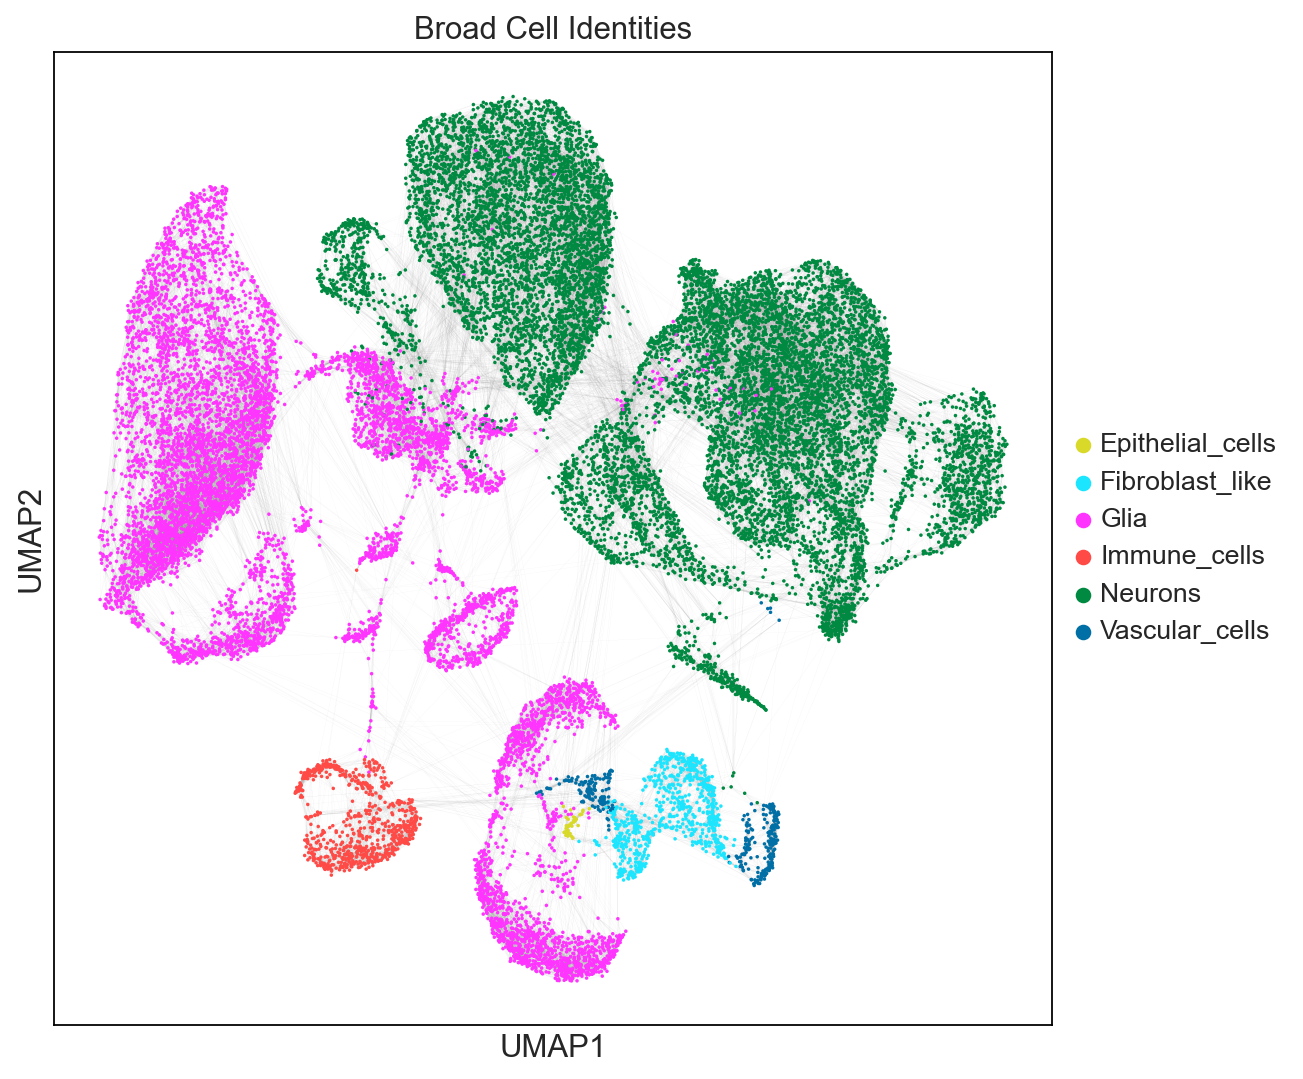

In [16]:
sc.set_figure_params(figsize=(8, 8))

sc.pl.umap(adata_final, 
           color=['final_broad_cell_types'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette=godsnot_64,
           size=10, 
         #  legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title="Broad Cell Identities",
           save= '_Final_Broad Cell Identities')

In [17]:
marker_genes_dict = {'Epithelial': ['TTR'],
                     'Immune cells': ['CX3CR1', 'C1QA'],
                     'Neurons': ['GRIN1', 'RBFOX3'],
                     'Glia': ['AQP4','MOBP','OLIG1','OLIG2'],
                     'Vascular cells': ['RGS5', 'VTN'],
                    'Fibroblast-like': ['DCN']}

/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


categories: Epithelial_cells, Fibroblast_like, Glia, etc.
var_group_labels: Epithelial, Immune cells, Neurons, etc.


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


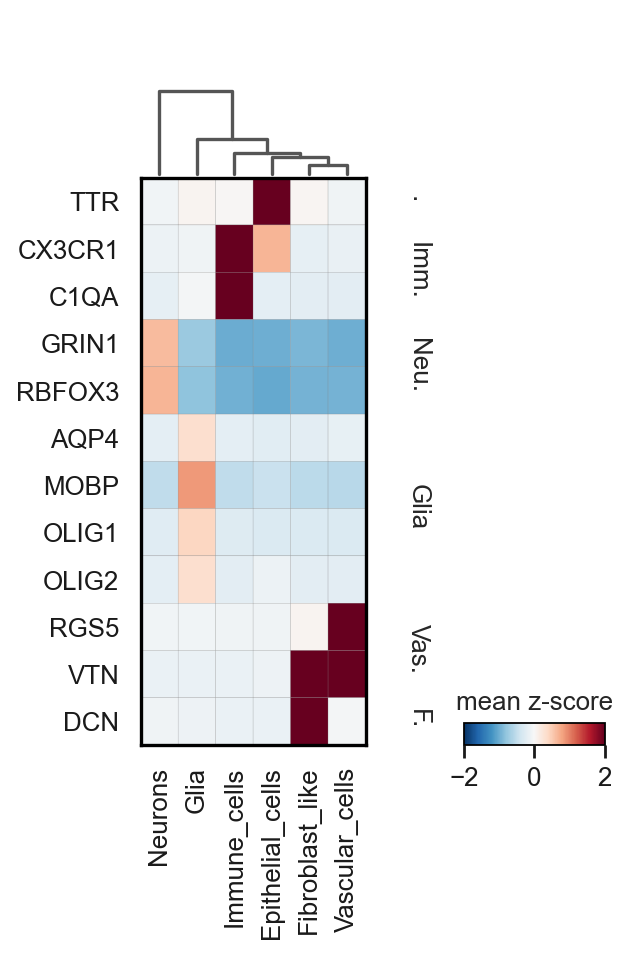

In [28]:
adata_final.layers['scaled'] = sc.pp.scale(adata_final, copy=True).X
sc.pl.matrixplot(adata_final, marker_genes_dict, groupby='final_broad_cell_types', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_Final_Broad Cell matrixplot')

categories: Epithelial_cells, Fibroblast_like, Glia, etc.
var_group_labels: Epithelial, Immune cells, Neurons, etc.


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


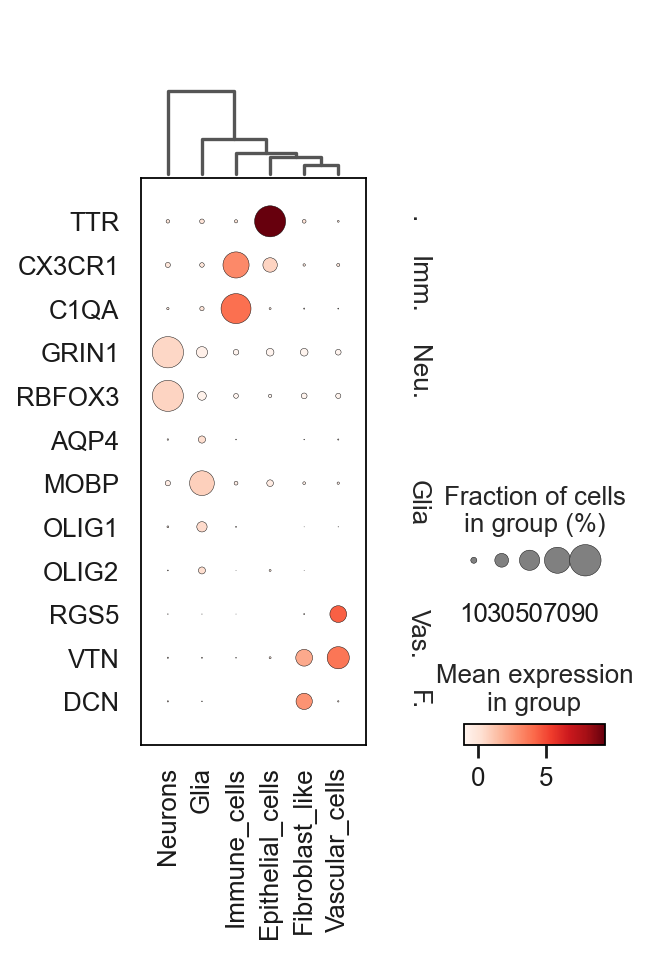

In [29]:
sc.pl.dotplot(adata_final, marker_genes_dict, groupby='final_broad_cell_types', dendrogram=True,layer='scaled',swap_axes=True,
             save= '_Final_Broad Cell dotplot')

/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


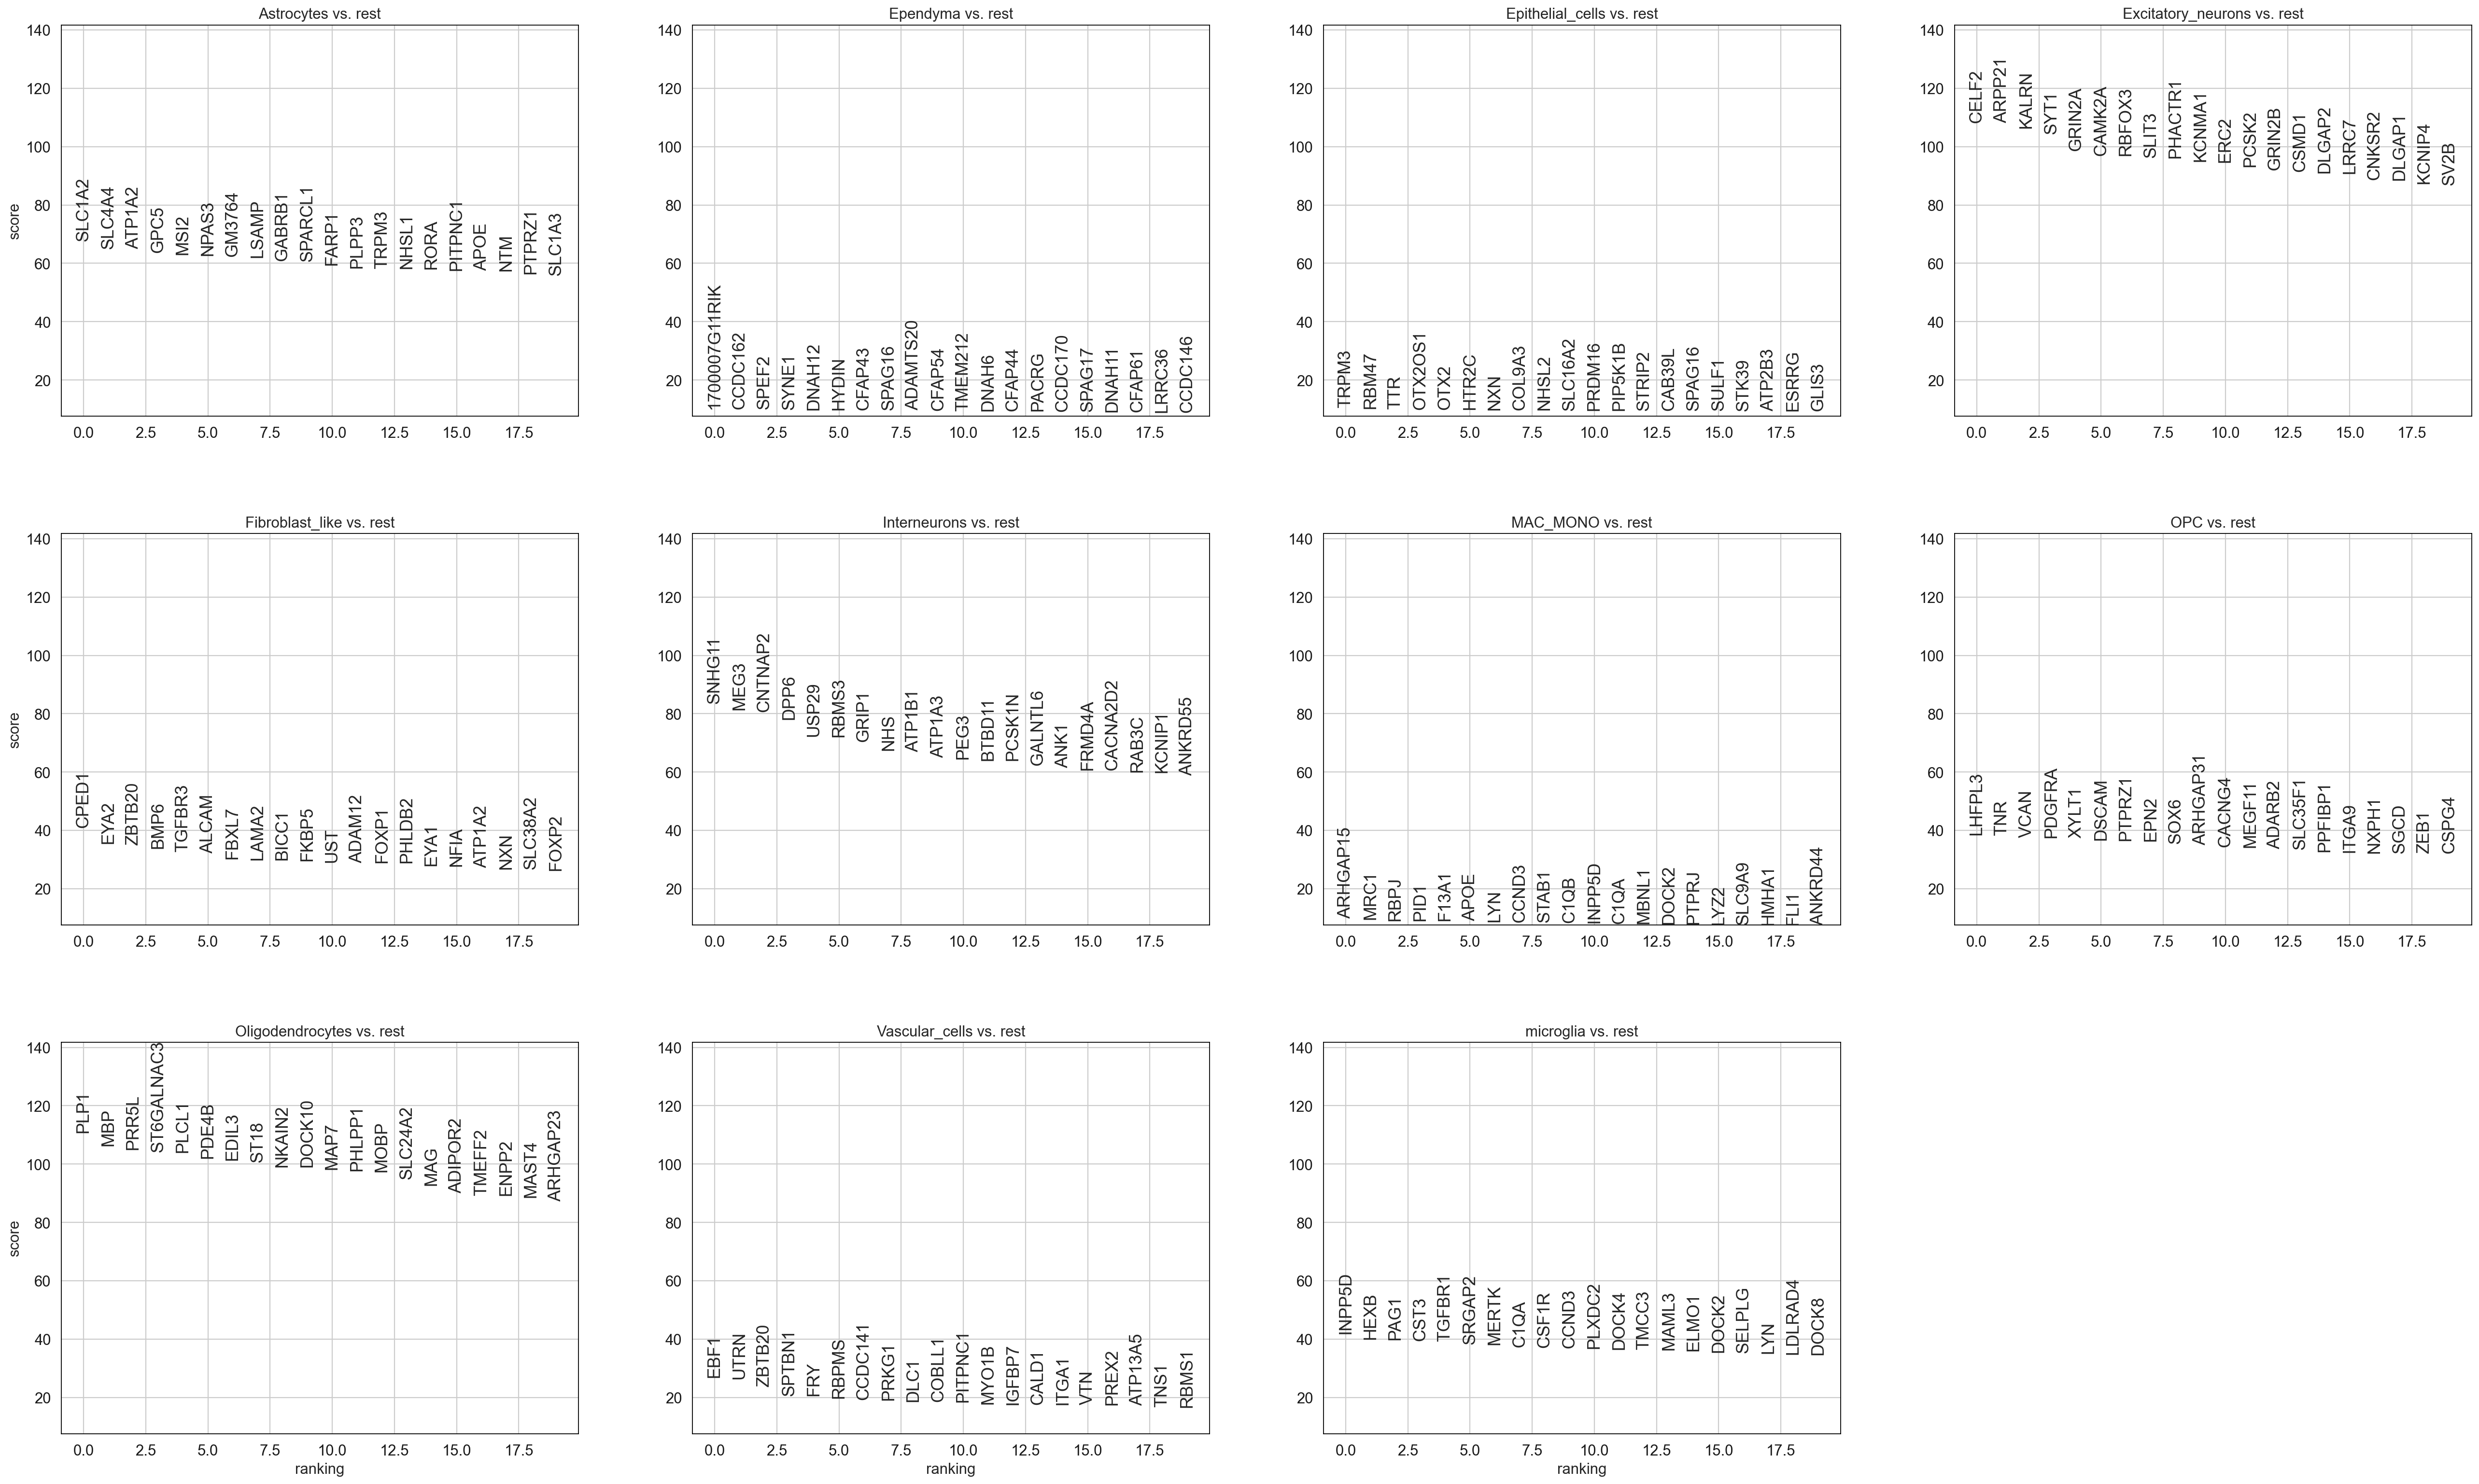

In [17]:
sc.set_figure_params(figsize=(10, 8))
sc.tl.rank_genes_groups(adata_final, groupby='final_subclusters', key_added="ranked_genes_final_sub", method='wilcoxon')
sc.pl.rank_genes_groups(adata_final, key = 'ranked_genes_final_sub', fontsize=16)



In [27]:
sc.pl.rank_genes_groups_heatmap(adata_final,key = 'ranked_genes_final_sub', n_genes=4, use_raw=False, 
                                swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', 
                                figsize=(22,12), show=False, save = '_final_subclusters_genes_')




/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='final_subclusters'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

# Top 10 significant genes heatmaps

## Neurons

In [57]:
adata_neurons = sc.read_h5ad(outdir+'adata_final_neuron_cells.h5ad')
cluster_neurons = dict()
cluster_neurons = {
    0 : 'Interneurons',
    1 : 'Interneurons',
    2 : 'Excitatory_neurons',
    3 : 'Oligodendrocytes',
    4 : 'Excitatory_neurons',
    5 : 'Excitatory_neurons',
    6 : 'Excitatory_neurons',
    7 : 'Excitatory_neurons',
    8 : 'Interneurons',
    9 : 'Excitatory_neurons',
    10 : 'Excitatory_neurons',
    11 : 'Interneurons',
    12 : 'Excitatory_neurons',
    13 : 'Excitatory_neurons',
    14 : 'Interneurons',
    15 : 'Excitatory_neurons',
    16 : 'Excitatory_neurons',
    17 : 'Excitatory_neurons',
    18 : 'Excitatory_neurons',
    19 : 'Oligodendrocytes',
    20 : 'Excitatory_neurons',
    21 : 'Excitatory_neurons'}
adata_neurons.obs['Neuron_cell_types'] = adata_neurons.obs['PhenoGraph_clusters_neurons'].map(cluster_neurons).astype('category')
adata_neurons.obs['Neuron_cell_types'].value_counts()



adata_neurons2 = deepcopy(adata_neurons)
adata_neurons2 = adata_neurons2[adata_neurons2.obs['Neuron_cell_types'].isin(['Excitatory_neurons']),:]

adata_neurons2.obs







/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,Sample ID,Condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,PhenoGraph_clusters_neurons20,PhenoGraph_clusters_neurons25,PhenoGraph_clusters_neurons30,PhenoGraph_clusters_neurons35,PhenoGraph_clusters_neurons40,PhenoGraph_clusters_neurons45,PhenoGraph_clusters_neurons50,PhenoGraph_clusters_neurons,PhenoGraph_clusters_neurons_str,Neuron_cell_types
cell_barcodes,,,,,,,,,,,,,,,,,,,,,
125262248732571_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,2061,7.631432,4666.0,8.448272,21.131590,31.033005,42.970424,61.530219,...,8,6,7,5,7,8,7,6,6,Excitatory_neurons
236230110301620_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,3059,8.026170,8830.0,9.086023,23.386183,31.891280,42.129105,58.550396,...,1,2,2,2,2,2,2,2,2,Excitatory_neurons
170265211497206_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,2880,7.965893,8280.0,9.021719,20.628019,29.963768,40.821256,58.743961,...,6,9,8,8,8,4,6,5,5,Excitatory_neurons
195959603517798_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,3007,8.009031,8570.0,9.056140,24.445741,33.197200,43.150525,59.089848,...,8,6,7,5,7,8,7,6,6,Excitatory_neurons
195402151087030_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,1927,7.564238,3519.0,8.166216,18.954248,26.541631,36.942313,56.351236,...,9,10,10,9,10,10,11,10,10,Excitatory_neurons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230604152166638_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,2731,7.912789,5601.0,8.630879,17.086235,24.370648,33.851098,51.294412,...,3,3,4,3,5,6,5,4,4,Excitatory_neurons
157140481395571_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,2062,7.631917,4481.0,8.407825,23.476902,31.890203,42.289667,60.299040,...,5,5,6,4,6,7,8,7,7,Excitatory_neurons
226949805788068_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,3129,8.048788,9482.0,9.157256,25.384940,33.336849,42.870702,58.995992,...,1,2,2,2,2,2,2,2,2,Excitatory_neurons


In [73]:
marker_genes_dict = dict()

marker_genes_dict = {'Exci-Cortex':["CAMK2A",
"GM44511",
"SNHG11",
"PDZD2",
"NAV3",
"SGCZ",
"MEG3",
"DPP10",
"ZMYND8",
"DGKI"],
'Exci-Brainstem':["GM44511",
"GRM8",
"NFIB",
"TCF4",
"TCF7L2",
"ZFP521",
"FOXP2",
"UBE3A",
"RGS6",
"GLS"]}

In [59]:
marker_genes_dict2 = {'Inhib-Cortex':["SNHG11",
"AC149090.1",
"GM44511",
"MDM1",
"JMJD1C",
"MEG3",
"MED23",
"CLIP1",
"PNISR"],
'Inhib-Brainstem':["UBE3A",
"GM26804",
"SON",
"CMSS1",
"AC149090.1",
"GM20388",
"CTNNA3",
"MEG3","CAMK1D",
"ERDR1"]}

# Heatmaps Glia

In [68]:
adata_glia = sc.read_h5ad(outdir+'adata_final_glia_cells.h5ad')
cluster_glia = dict()
cluster_glia = {
    0 : 'Oligodendrocytes',
    1 : 'Oligodendrocytes',
    2 : 'Astrocytes',
    3 : 'Oligodendrocytes',
    4 : 'Oligodendrocytes', 
    5 : 'Astrocytes',
    6 : 'Oligodendrocytes',
    7 : 'Oligodendrocytes',
    8 : 'Oligodendrocytes',
    9 : 'Astrocytes',
    10 : 'OPC',
    11 : 'OPC',
    12 : 'Oligodendrocytes',
    13 : 'Oligodendrocytes',
    14 : 'Astrocytes',
    15 : 'OPC',
    16 : 'Astrocytes',
    17 : 'OPC',
    18 : 'OPC',
    19 : 'Ependyma'}
adata_glia.obs['Glia_cell_types'] = adata_glia.obs['PhenoGraph_clusters_glia'].map(cluster_glia).astype('category')
adata_glia.obs['Glia_cell_types'].value_counts()

Oligodendrocytes    4748
Astrocytes          1782
OPC                  622
Ependyma              34
Name: Glia_cell_types, dtype: int64

In [69]:
marker_genes_dict = dict()
marker_genes_dict['All'] = ['TIMP4','GPR37L1','MBP','MOBP','NEU4','PDGFRA','CCDC153']
#marker_genes_dict['Oligodendrocytes'] = ['MBP','MOBP']
#marker_genes_dict['OPC'] = ['NEUA','PDGFRA']
#marker_genes_dict['Ependyma'] = ['CCDC153']

categories: Astrocytes, Ependyma, OPC, etc.
var_group_labels: All


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


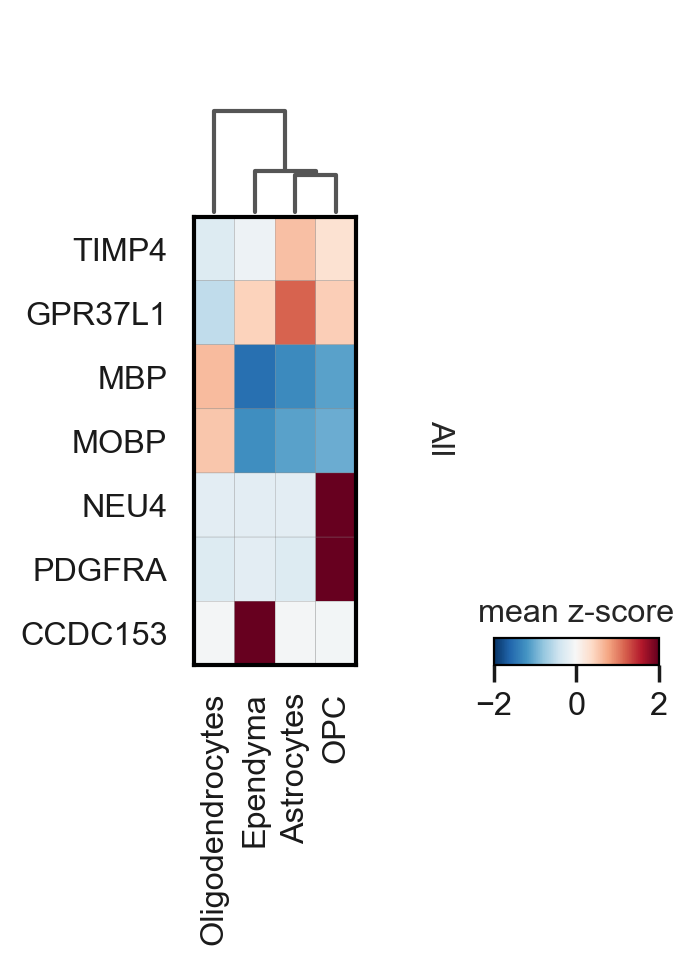

In [47]:
adata_glia.layers['scaled'] = sc.pp.scale(adata_glia, copy=True).X
sc.pl.matrixplot(adata_glia, marker_genes_dict, groupby='Glia_cell_types', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_Glia_celltypes_heatmap'
                )

In [56]:
marker_genes_dict = dict()

marker_genes_dict = {'Astrocytes-Cortex':['PDE10A',
'FKBP5',
'ASIC2',
'MAT2A',
'PROM1',
'TTYH1',
'MDGA2',
'CCND3',
'CACNB4'],
'Astrocytes-Brainstem':['FKBP5',
'MEG3',
'NELL2',
'SPON1',
'PLIN4',
'KCNT1',
'FAM19A1',
'C4B',
'CPE']}



In [57]:
marker_genes_dict2 = {'Oligo-Cortex':['PTGDS',
'PLIN4',
'FKBP5',
'DTNB',
'SGK3',
'APOD',
'ADIPOR2',
'ELMO1',
'GLI2'],
'Oligo-Brainstem':['CAMK1D',
'FKBP5',
'DTNB',
'PLIN4',
'SGK3',
'C4B',
'HTRA1',
'ZFAND4',
'MEG3']}

categories: Astrocytes, Ependyma, Epithelial_cells, etc.
var_group_labels: Astrocytes-Cortex, Astrocytes-Brainstem


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


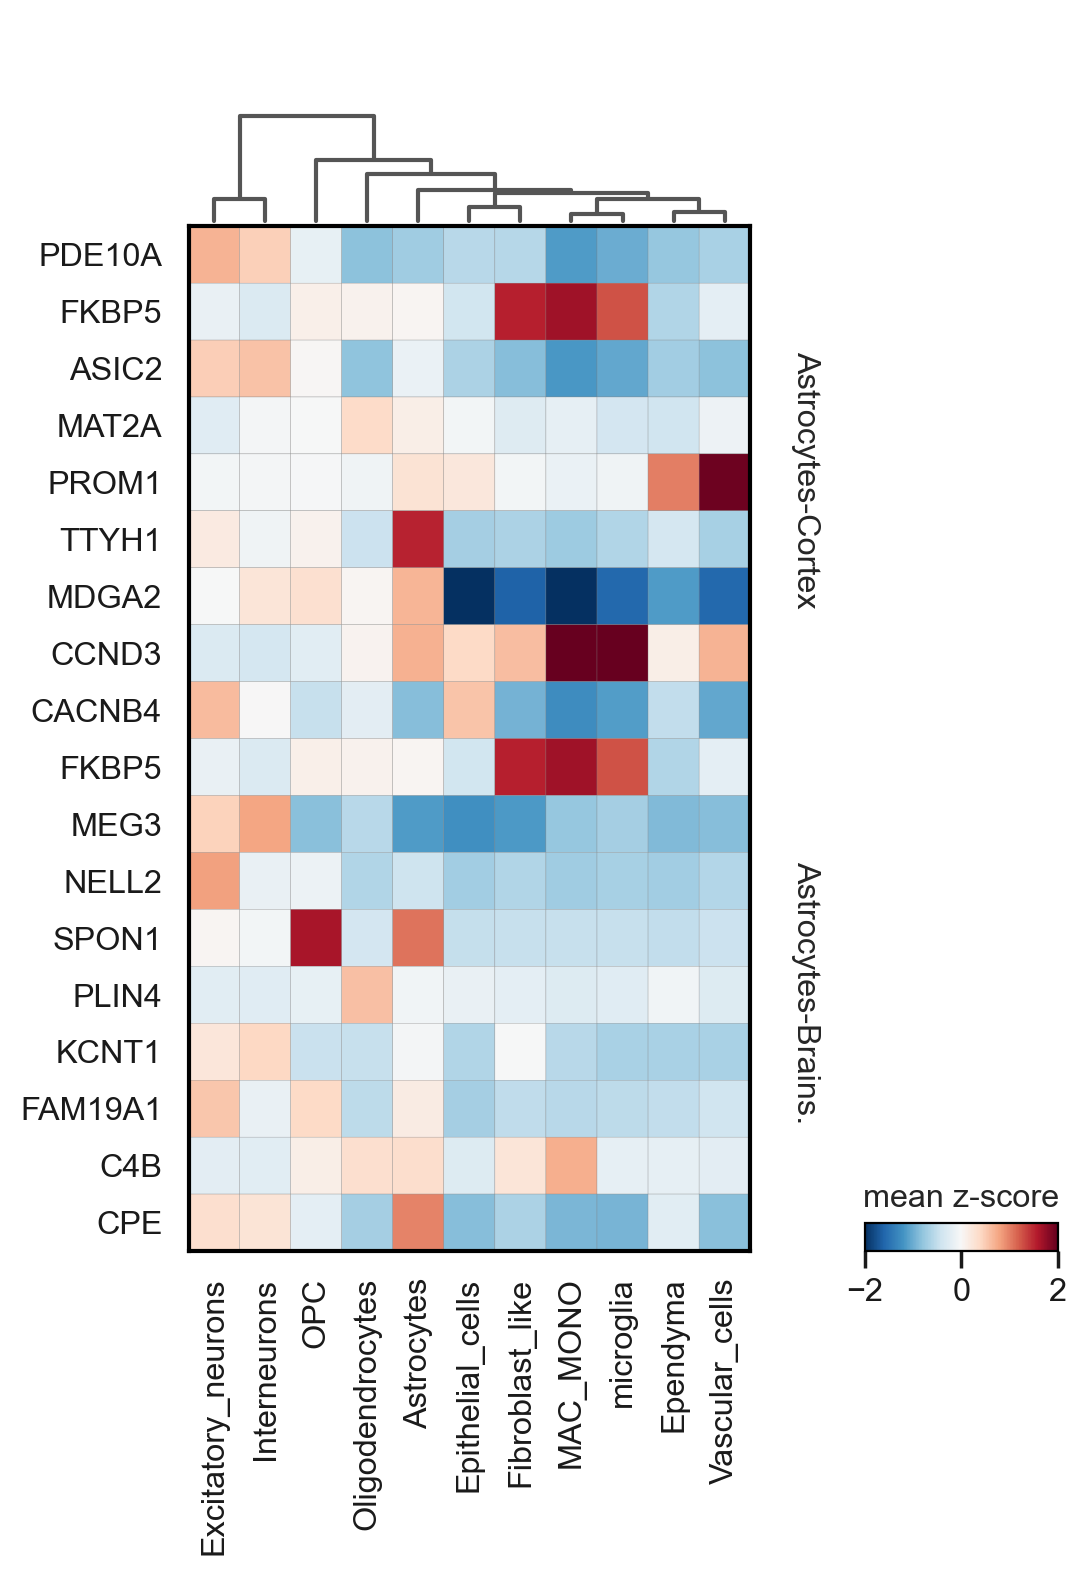

/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


categories: Astrocytes, Ependyma, Epithelial_cells, etc.
var_group_labels: Oligo-Cortex, Oligo-Brainstem


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


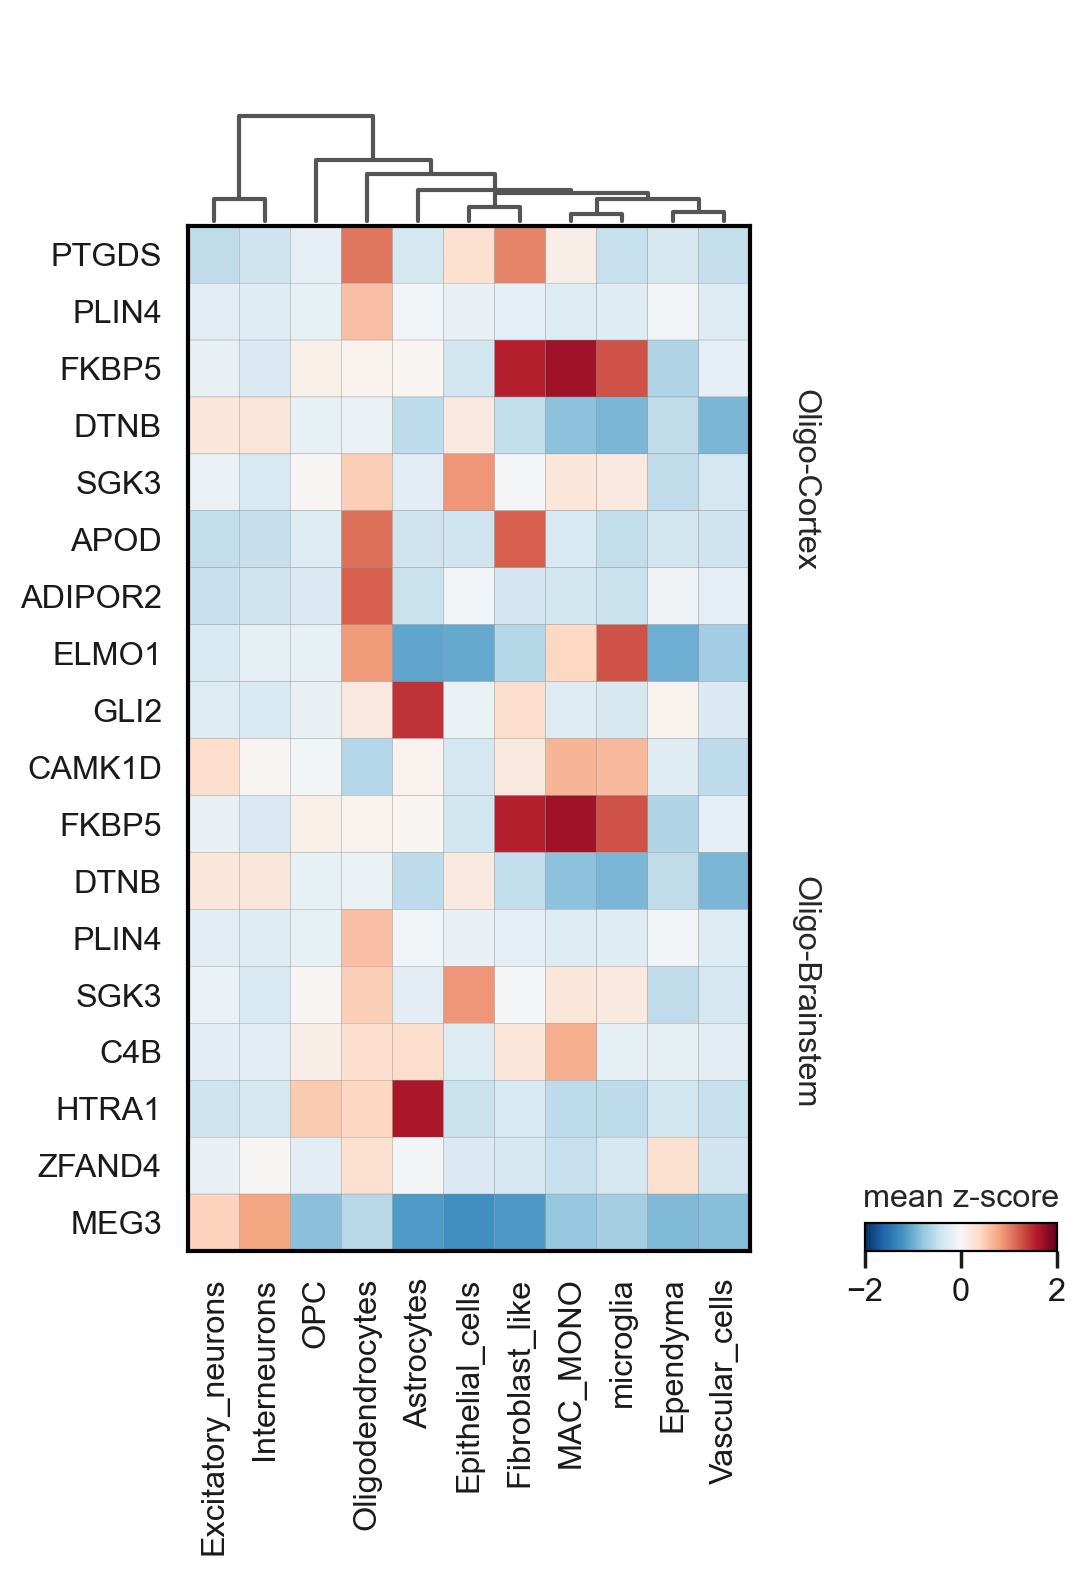

In [62]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
adata_final.layers['scaled'] = sc.pp.scale(adata_final, copy=True).X
sc.pl.matrixplot(adata_final, marker_genes_dict, groupby='final_subclusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_Top significant genes Astro'
                )




adata_final.layers['scaled'] = sc.pp.scale(adata_final, copy=True).X
sc.pl.matrixplot(adata_final, marker_genes_dict2, groupby='final_subclusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_Top significant genes Oligo'
                )


# Heatmaps Immune cells

In [10]:
adata_immune_cells = sc.read_h5ad(outdir+'adata_final_immune_cells.h5ad')
cluster_dict_imm = dict()
cluster_dict_imm = {
    0 : 'Microglia',
    1 : 'Microglia',
    2 : 'Microglia', 
    3 : 'Oligodendrocytes', 
    4 : 'Microglia', 
    5 : 'Microglia',
    6 : 'Microglia',
    7 : 'MAC_MONO'}
adata_immune_cells.obs['Immune_cell_types'] = adata_immune_cells.obs['PhenoGraph_clusters_immune'].map(cluster_dict_imm).astype('category')
adata_immune_cells.obs['Immune_cell_types'].value_counts()

Microglia           678
Oligodendrocytes    121
MAC_MONO             47
Name: Immune_cell_types, dtype: int64

In [69]:
marker_genes_dict = dict()
marker_genes_dict['All'] = ['CX3CR1','P2RY12','PF4','F13A1', 'MOBP', 'MBP']
#marker_genes_dict['Oligodendrocytes'] = ['MBP','MOBP']
#marker_genes_dict['OPC'] = ['NEUA','PDGFRA']
#marker_genes_dict['Ependyma'] = ['CCDC153']

categories: MAC_MONO, Microglia, Oligodendrocytes
var_group_labels: All


/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


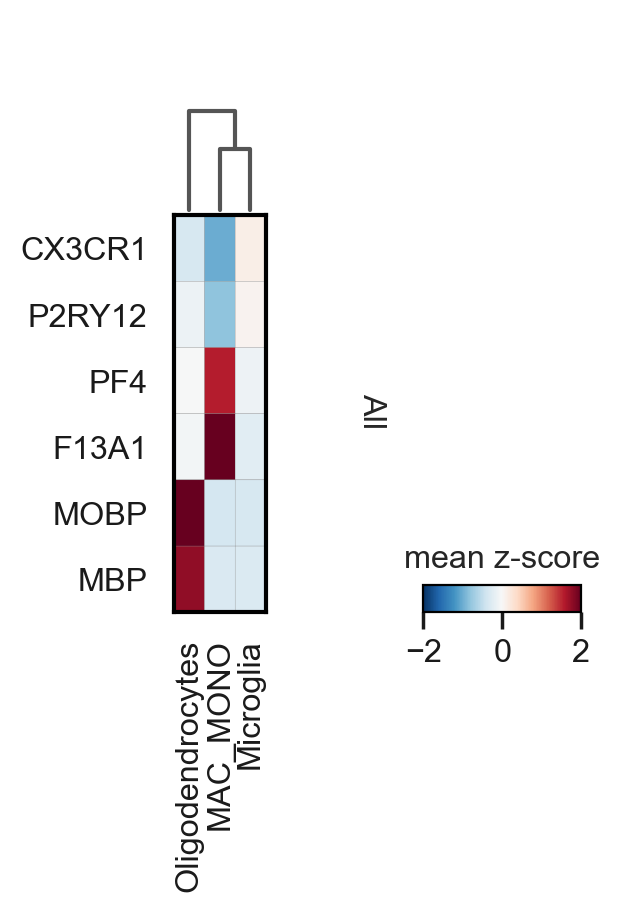

In [70]:
adata_immune_cells.layers['scaled'] = sc.pp.scale(adata_immune_cells, copy=True).X
sc.pl.matrixplot(adata_immune_cells, marker_genes_dict, groupby='Immune_cell_types', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_immune_celltypes_heatmap'
                )

In [13]:
marker_genes_dict = dict()

marker_genes_dict = {'Microglia-BS':['APOE',
'AXL',
'CTSH',
'ATP8A1',
'APOBEC1',
'ABR',
'AGFG1',
'MYO1F',
'MEG3',
'FTH1',
'RASSF3',
'PID1',
'MAGI2',
'NRXN1',
'LYZ2',
'SPP1',
'PCDH9',
'FGF14',
'CSF3R',
'MYO5A',
'ZFYVE26',
'RTN3',
'PLEKHA1',
'NRP1',
'RFTN1',
'MYO9B',
'RPS6KA3',
'PVT1',
'DCC',
'FMN1',
'FN1']}

adata_immune_cells2 = deepcopy(adata_immune_cells)
adata_immune_cells2 = adata_immune_cells2[adata_immune_cells2.obs['PhenoGraph_clusters_immune_str2'].isin(['0','1','2','4','5','6']),:]
adata_immune_cells2.obs

/Users/fragkogs/opt/anaconda3/envs/my_braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,Sample ID,Condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,PhenoGraph_clusters_immune20,PhenoGraph_clusters_immune25,PhenoGraph_clusters_immune30,PhenoGraph_clusters_immune35,PhenoGraph_clusters_immune40,PhenoGraph_clusters_immune45,PhenoGraph_clusters_immune50,PhenoGraph_clusters_immune,PhenoGraph_clusters_immune_str2,Immune_cell_types
cell_barcodes,,,,,,,,,,,,,,,,,,,,,
226970322517356_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,1194,7.085901,1546.0,7.344073,13.906856,21.798189,34.734799,55.109961,...,1,1,1,1,2,2,0,1,1,Microglia
235128466586981_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,1106,7.009409,1569.0,7.358831,16.826004,25.812620,38.559592,61.376673,...,2,3,3,3,3,3,2,2,2,Microglia
235686958913260_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,897,6.800170,1123.0,7.024649,15.405165,24.309884,37.934105,64.648264,...,1,1,1,1,2,2,0,1,1,Microglia
200975960107749_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,658,6.490724,810.0,6.698268,18.271605,30.617284,43.456790,80.493827,...,3,4,5,4,5,5,4,4,4,Microglia
191697876858733_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,1032,6.940222,1373.0,7.225482,15.731974,23.525127,38.091770,61.252731,...,0,0,0,0,1,0,1,0,0,Microglia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130599865506588_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,788,6.670766,1017.0,6.925595,20.058997,29.891839,42.182891,71.681416,...,3,4,5,4,5,5,4,4,4,Microglia
200967504739749_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,1095,6.999422,1652.0,7.410347,17.554479,26.997579,39.648910,63.983051,...,2,3,3,3,3,3,2,2,2,Microglia
126834220879203_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,1168,7.063904,1580.0,7.365813,15.632911,23.417722,36.075949,57.721519,...,0,0,0,0,1,0,1,6,6,Microglia


/Users/fragkogs/opt/anaconda3/envs/my_braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<AxesSubplot:xlabel='gene', ylabel='value'>

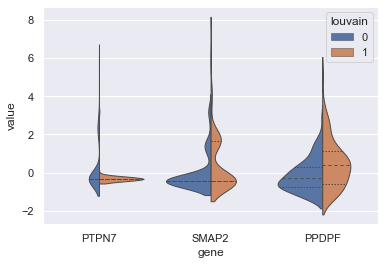

In [26]:
adata = sc.datasets.pbmc68k_reduced()
adata = adata[adata.obs.louvain.isin(['0','1'])].copy()
df = sc.get.obs_df(adata, ['PTPN7', 'SMAP2', 'PPDPF', 'louvain'])
df = df.set_index('louvain').stack().reset_index()
df.columns = ['louvain', 'gene', 'value']
import seaborn as sns
sns.violinplot(data=df, x='gene', y='value', hue="louvain",
                split=True, inner="quart", linewidth=1)      

In [63]:
my_adata = adata_immune_cells2[adata_immune_cells2.obs.PhenoGraph_clusters_immune_str2.isin(['1'])].copy()
my_adata.obs.Condition.value_counts()


/Users/fragkogs/opt/anaconda3/envs/my_braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


VE         133
Control      1
Name: Condition, dtype: int64

<AxesSubplot:xlabel='gene', ylabel='value'>

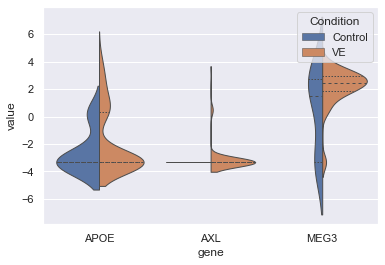

In [62]:
df = sc.get.obs_df(my_adata, ['APOE', 'AXL','MEG3' ,'Condition'])
df = df.set_index('Condition').stack().reset_index()
df.columns = ['Condition', 'gene', 'value']
df

sns.violinplot(data=df, x='gene', y='value', hue="Condition",
                split=True, inner="quart", linewidth=1)      

In [25]:
sc.pl.violin(adata_immune_cells, )

AxisArrays with keys: X_pca, X_umap

In [ ]:
sns.violinplot(data = adata_immune_cells, x="PhenoGraph_clusters_immune_str2", y="total_bill", hue="Condition",
                     palette="muted", split=True)

/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/braf_env/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


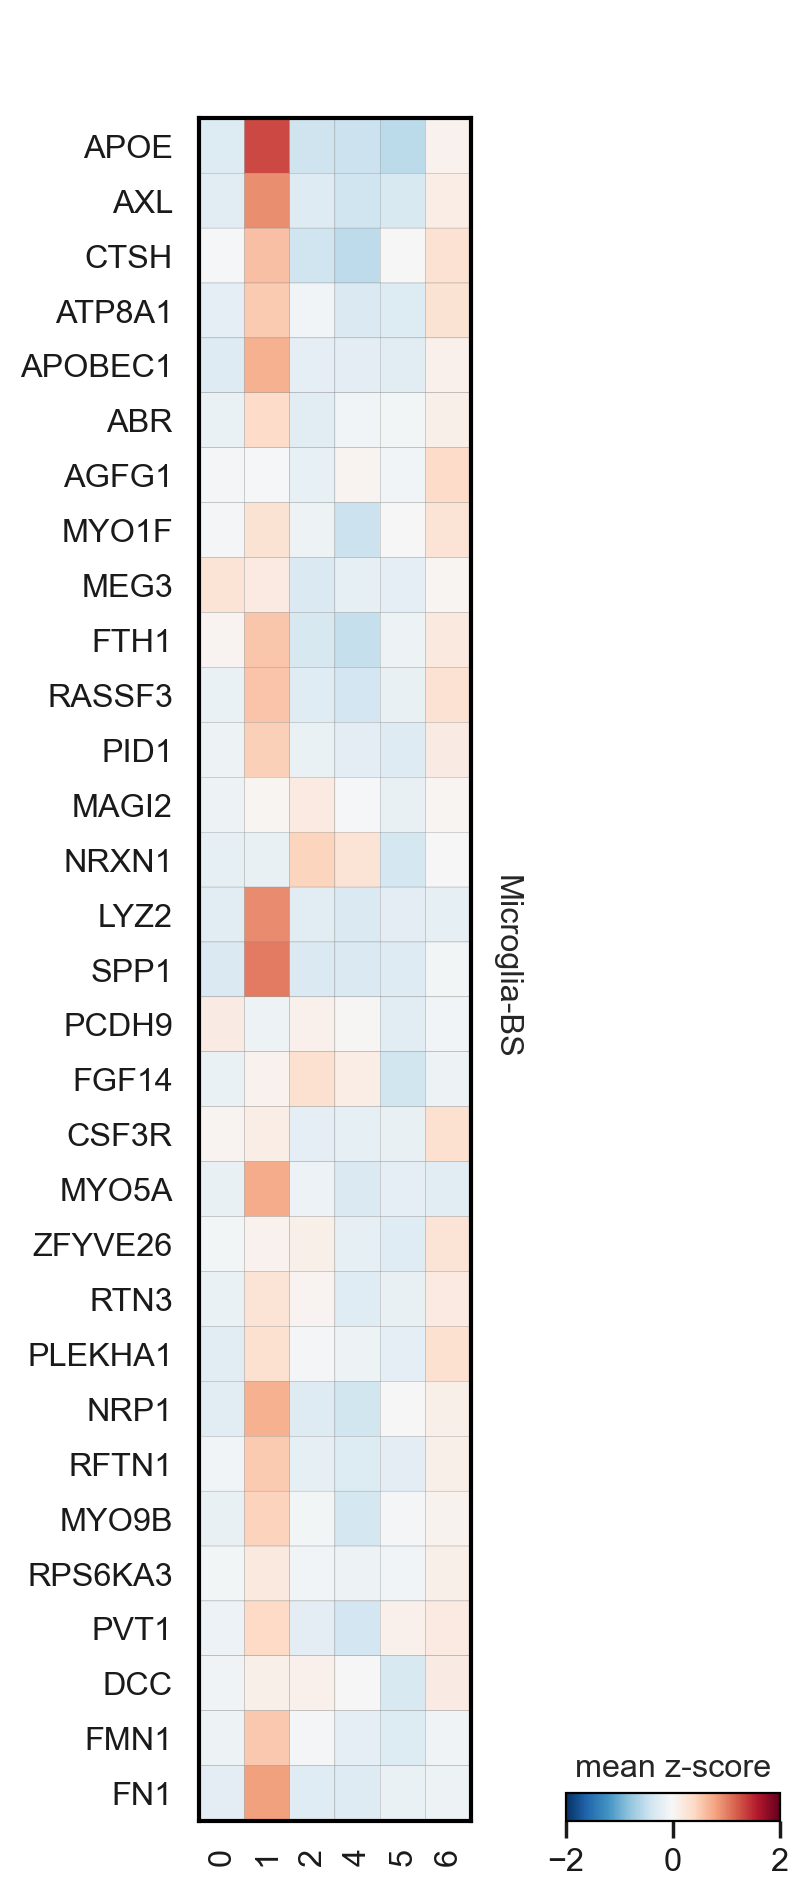

In [48]:

adata_immune_cells2.layers['scaled'] = sc.pp.scale(adata_immune_cells2, copy=True).X
sc.pl.matrixplot(adata_immune_cells2, marker_genes_dict, groupby='PhenoGraph_clusters_immune_str2', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True,
                save= '_microglia_upreg_genes_heatmap'
                )



In [1]:
pip install bioinfokit

     |████████████████████████████████| 82 kB 432 kB/s eta 0:00:01
  Created wheel for bioinfokit: filename=bioinfokit-1.0.8-py3-none-any.whl size=55963 sha256=8d0acddc70051a053c2855fbf8341d808c96c21be5900ff70ee3e42a94b5a567
  Stored in directory: /Users/fragkogs/Library/Caches/pip/wheels/0d/86/0b/c4e0cff1138445714c2a89e71911bdaf558a3c228dc4d12ae5
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=0fe16e9ee67becb118b7d0c05a7ef8b746724fc6e2e7f8e893d9470b82c7e3d0
  Stored in directory: /Users/fragkogs/Library/Caches/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=32062 sha256=76abd5d464b7f7c749845bc7c18ebdb856d87523ddf2bdb1fcff3aa635836f9d
  Stored in directory: /Users/fragkogs/Library/Caches/pip/wheels/82/e4/64/dd790d424818bc2f59c11471a1eee5dc8cfcd3f8ee8c4812fa
Successfully built bioinfokit adjustText matplotlib-venn
Note: you may nee

In [2]:
pip install bioinfokit --upgrade

Note: you may need to restart the kernel to use updated packages.


# Volcano plots

In [3]:
from bioinfokit import analys, visuz

In [47]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 

file = './DEA/Excitatory_neurons/MAST_DEA_Excitatory_neurons_bs.xls'
df = pd.read_excel(file)
#print(df['Occupation'])

In [48]:
df.head()

,gene,p,p.fdr.adj,logFC
0,GM44511,1.080000e-93,2.040000e-89,-0.823073
1,GRM8,7.960000e-61,7.540000e-57,-1.782870
2,NFIB,1.490000e-49,9.430000e-46,-1.063933
3,TCF4,6.170000e-48,2.920000e-44,-1.107583
4,TCF7L2,2.560000e-45,9.710000e-42,0.868934


In [49]:
df.rename(columns={'gene': 'GeneNames'}, inplace=True)

In [51]:
df=df.dropna(axis=0, how='any')

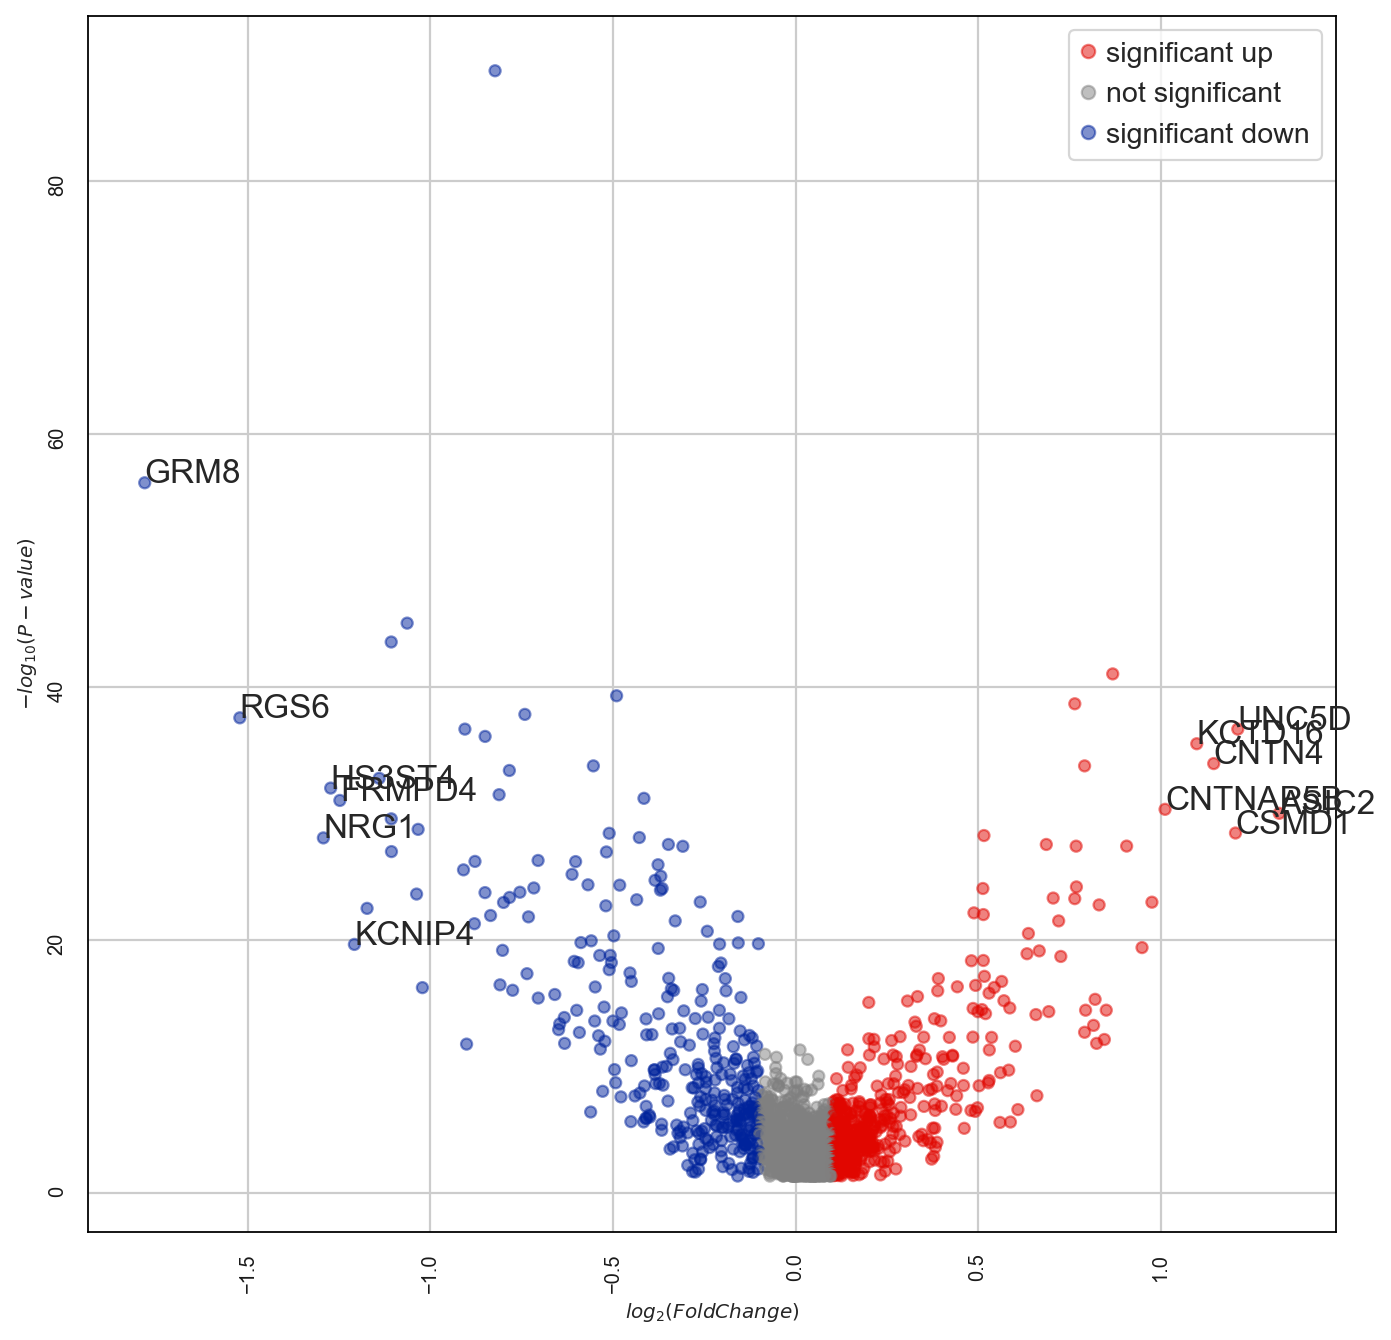

In [79]:
sc.set_figure_params(figsize=(20, 20))
visuz.gene_exp.volcano(df=df, 
                       lfc='logFC', 
                       pv='p.fdr.adj',
                       lfc_thr=(0.1, 0.1),
                       pv_thr=(0.5, 0.05), color=("#E10600FF" ,"grey", "#00239CFF"), 
                       plotlegend=True, 
                       legendpos='best',
                       valpha=0.5,
                       show = True, 
                       geneid="GeneNames",
                       gstyle=1, 
                       genenames = ('ASIC2','UNC5D', 'CSMD1','CNTN4','KCTD16','CNTNAP5B','GRM8','RGS6','NRG1','HS3ST4','FRMPD4','KCNIP4'), 
                       dim = (10, 10),
                       dotsize = 25,
                       gfont = 15
                      )


